In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import torch
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.benchmark = False

In [3]:
torch.cuda.is_available()

True

In [4]:
# specify that the outcome of interest for this notebook is Progressive Diseasea
outcome='pd_true'

In [7]:
import torch

cuda = torch.device('cuda')     # Default CUDA device
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')  


# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device(cuda)

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(cuda))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: NVIDIA RTX A6000


In [8]:
prefix = './'

In [9]:
all_reports = pd.read_csv(prefix + 'timc_recist_labeled_dataset_id.csv')
all_reports['report_length'] = all_reports.report_text.str.len()
all_reports['date'] = pd.to_datetime(all_reports.date)
all_reports = all_reports.sort_values(by=['obs','dfci_mrn','date'])
all_reports['text'] = all_reports["report_text"]
all_reports['text'] = all_reports.text.str.lower().str.replace("\r|\n", " ")
all_reports['text'] = all_reports.text.str.replace('\s+', ' ')

/tmp/ipykernel_2535/1554159933.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  all_reports['text'] = all_reports.text.str.lower().str.replace("\r|\n", " ")
/tmp/ipykernel_2535/1554159933.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  all_reports['text'] = all_reports.text.str.replace('\s+', ' ')


In [10]:
# deduplicate reports
all_reports = all_reports.drop_duplicates(subset=['dfci_mrn','text'])

In [11]:
all_reports.shape

(63897, 14)

In [12]:
all_reports['starttime'] = all_reports.groupby('obs').date.transform('first')
all_reports['time'] =  (all_reports['date'] - all_reports['starttime']).dt.days

In [13]:
all_reports.shape

(63897, 16)

In [14]:
all_reports['timepoint_id'] = all_reports.groupby(['dfci_mrn','date']).ngroup()

In [15]:
all_reports.overall_response_factor.value_counts()

3    20140
0    15935
1    15396
4     9188
2     3238
Name: overall_response_factor, dtype: int64

In [16]:
all_reports.overall_response.value_counts()

SD    20140
BL    15935
PR    15396
PD     9188
CR     3238
Name: overall_response, dtype: int64

In [17]:
all_reports['prcr_true'] = np.where(all_reports.overall_response.isin(['PR','CR']), 1, 0)
all_reports['pd_true'] = np.where(all_reports.overall_response == 'PD', 1, 0)

all_reports['outcome'] = np.where(all_reports.overall_response == 'BL', -1, 0)
all_reports['outcome'] = np.where(all_reports[outcome]==1, 1, all_reports['outcome'])
print(all_reports.outcome.value_counts())
print(all_reports.prcr_true.value_counts())
print(all_reports.pd_true.value_counts())
all_reports['is_bl'] = np.where(all_reports.overall_response == 'BL', True, False)

good_obs = all_reports.groupby('obs').is_bl.all().reset_index()
good_obs = good_obs[good_obs.is_bl == False]

all_reports = pd.merge(all_reports, good_obs[['obs']], on='obs')

print(all_reports.outcome.value_counts())
print(all_reports.prcr_true.value_counts())
print(all_reports.pd_true.value_counts())

 0    38774
-1    15935
 1     9188
Name: outcome, dtype: int64
0    45263
1    18634
Name: prcr_true, dtype: int64
0    54709
1     9188
Name: pd_true, dtype: int64
 0    38774
-1    12630
 1     9188
Name: outcome, dtype: int64
0    41958
1    18634
Name: prcr_true, dtype: int64
0    51404
1     9188
Name: pd_true, dtype: int64


In [18]:
training = all_reports[all_reports['split'] == 'train']
validation = all_reports[all_reports['split'] == 'validation']
test = all_reports[all_reports['split'] == 'test']

In [19]:
from torch.utils import data
import torch.nn.functional as F
from transformers import AutoTokenizer

class RecistDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset
        self.max_doc_len = 512
        self.tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
        self.observations = self.data.timepoint_id.unique()
        
    def __len__(self):
        # how many observations (pt-date combos) in the dataset
        return len(self.observations)
    
    def __getitem__(self, index):
        # get data for timepoint corresponding to index passed
        thisobs = self.observations[index]
        obs = self.data[self.data.timepoint_id == thisobs].copy().reset_index(drop=True)
        
        obs['date'] = pd.to_datetime(obs['date'])
        obs = obs.sort_values(by=['date'])

        start_times = torch.tensor(obs.time / 365, dtype=torch.float32)

    
        y_outcome = torch.tensor(obs['outcome'], dtype=torch.float32)

        text = obs.text.tolist()
        
        
        encoded_list = self.tokenizer(text, padding='max_length', max_length=self.max_doc_len, truncation=True)
        input_ids = torch.tensor(encoded_list['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(encoded_list['attention_mask'], dtype=torch.long) 

        return input_ids, attention_mask, start_times, y_outcome

    

        

In [21]:
#model 
import math
from transformers import AutoModel
from torch.nn import functional as F
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, GRUCell, Dropout, AdaptiveMaxPool1d
from recistmodels import HTransformer
    
    

###### from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 150):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

    
class RecistModel(nn.Module):


    def __init__(self):
        super(RecistModel, self).__init__()
        
        self.day_tensor_dim = 768
        self.per_doc_hidden_dim = 256
        
        self.final_hidden_dim = 128
        self.class_output_dim=1

        self.note_bert = AutoModel.from_pretrained('medicalai/ClinicalBERT')

        self.per_doc_hidden = Linear(self.day_tensor_dim, self.per_doc_hidden_dim)
        
        self.day_transformer = HTransformer(emb=self.per_doc_hidden_dim, heads=4, depth=1)
        
        self.day_position_encoding = PositionalEncoding(self.per_doc_hidden_dim)
        
        self.final_hidden = Linear(self.per_doc_hidden_dim, self.final_hidden_dim)
        
        self.recist_out = Linear(self.final_hidden_dim, self.class_output_dim)

        

        

    def forward(self, input_ids, mask, start_times):

        
        input_ids = input_ids.squeeze(0)
        mask = mask.squeeze(0)
        start_times = start_times.squeeze(0) # now (num_docs,)
        
        main = self.note_bert(input_ids, mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)
        
        main = self.per_doc_hidden(main)

        # batch = sequence_length, embedding
        # permute to get position encoding along temporal dimension
        # add a single batch dimension, then position encode, then remove
        main = main.unsqueeze(1)
        main = self.day_position_encoding(main)
        main = main.squeeze(1)
        
        # figure out unique start times.
        unique_start_times = torch.unique(start_times)
        
        # loop over unique start times
        day_tensor_list = []
        for start_time in unique_start_times:
            day_input = main[start_times == start_time]
            
            # batch axis back
            day_input = day_input.unsqueeze(0)

            day_output = torch.max(day_input, axis=1)[0]

            day_tensor_list.append(day_output)
        day_tensors = torch.cat(day_tensor_list)
        

        # batch axis back for hierarchical transformer
        day_tensors = day_tensors.unsqueeze(0)

        main = self.day_transformer(day_tensors)
        main = self.final_hidden(main)
        main = F.relu(main)
        
        # remove batch axis again
        main = main.squeeze(0)
        main = self.recist_out(main).squeeze(1)
             
        return main


In [22]:
training = training[training['text'].notna()]
validation = validation[validation['text'].notna()]
test = test[test['text'].notna()]
print(training.shape)
print(validation.shape)
print(test.shape)

(49019, 21)
(5477, 21)
(6096, 21)


In [23]:
# train loop
from transformers import get_scheduler, get_linear_schedule_with_warmup
from torch.optim import AdamW, Adam

def train_model(model, num_epochs, trainloader, validloader):
    
    
    import torch.optim as optim
    
    num_training_steps = num_epochs * len(trainloader)

    
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps = num_epochs * num_training_steps)  # PyTorch scheduler
    
    model.to(device)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_train_main_loss = 0.0
        mean_train_main_loss = 0.0

        
        running_val_main_loss = 0.0
        mean_val_main_loss = 0.0

        
        num_train_batches = len(trainloader)
                
        model.train()

        
        for i, batch in enumerate(trainloader, 0):
            ids, mask, s_times, y_true  = [x.to(device) for x in batch]

            #get rid of batch1 axis from target labels
            y_true = y_true.squeeze(0)


            y_true_list = []
            
            unique_times = torch.unique(s_times)
 
            for unique_time in unique_times:
                y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])
           
            y_true = torch.stack(y_true_list, dim=0)
           
            optimizer.zero_grad()
            pred_recist = model(ids, mask, s_times)
            
            y_true_use = y_true[y_true != -1]
            pred_recist_use = pred_recist[y_true != -1]
            
    
            
            if(pred_recist_use.shape[0] > 0):
                loss = F.binary_cross_entropy_with_logits(pred_recist_use, y_true_use)            
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            else:
                loss = torch.tensor(0)
            
            running_train_main_loss += loss.data.cpu().numpy()
            mean_train_main_loss = running_train_main_loss / (i+1)

            del ids, mask, s_times, y_true, pred_recist
                
            # print statistics
            print('Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ', main train loss: ' + str(mean_train_main_loss), end='\r', flush=True)


             
        print('')
            
        if validloader is not None:
            # validate
            valid_batches = len(validloader)

            model.eval()

            for j, vbatch in enumerate(validloader, 0):

                ids, mask, s_times, y_true  = [x.to(device) for x in vbatch]
                
                #get rid of batch1 axis from target labels
                y_true = y_true.squeeze(0)

                y_true_list = []

                unique_times = torch.unique(s_times)
                for unique_time in unique_times:
                    y_true_list.append(y_true[s_times.squeeze(0) == unique_time][0,])

                y_true = torch.stack(y_true_list, dim=0)

                with torch.no_grad():
                    pred_recist = model(ids, mask, s_times)
            
                y_true_use = y_true[y_true != -1]
                pred_recist_use = pred_recist[y_true != -1]

                if(pred_recist_use.shape[0] > 0):
                    loss = F.binary_cross_entropy_with_logits(pred_recist_use, y_true_use)


                else:
                    loss = torch.tensor(0)


                running_val_main_loss += loss.data.cpu().numpy()
                
                del ids, mask, s_times, y_true, pred_recist
            mean_val_main_loss = running_val_main_loss / (j+1)
                

 

               
            print('Epoch: ' + str(epoch+1) + ', main val loss: ' + str(mean_val_main_loss), end='\r', flush=True)
        print('')
    



In [24]:
themodel = RecistModel().to(device)
trainloader = data.DataLoader(RecistDataset(training.reset_index(drop=True)), batch_size=1, num_workers=6, shuffle=True)

In [25]:
validloader = data.DataLoader(RecistDataset(validation.reset_index(drop=True)), batch_size=1, num_workers=2, shuffle=True)

In [27]:
train_model(themodel,3, trainloader, validloader)
torch.save(themodel.state_dict(), prefix+'./recist_bert_nolongitudinal_pd.pt')

In [28]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 44 to 60447
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               5477 non-null   int64         
 1   dfci_mrn                 5477 non-null   int64         
 2   date                     5477 non-null   datetime64[ns]
 3   report_text              5477 non-null   object        
 4   protocol                 5477 non-null   object        
 5   overall_response         5477 non-null   object        
 6   narrative_text           5476 non-null   object        
 7   impression_text          3255 non-null   object        
 8   drop_this_obs            5477 non-null   bool          
 9   split                    5477 non-null   object        
 10  obs                      5477 non-null   int64         
 11  overall_response_factor  5477 non-null   int64         
 12  report_length            5477 no

In [29]:
validation_day_text = validation.copy()
validation_day_text['text'] = validation_day_text.text.astype(str)
validation_day_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 44 to 60447
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               5477 non-null   int64         
 1   dfci_mrn                 5477 non-null   int64         
 2   date                     5477 non-null   datetime64[ns]
 3   report_text              5477 non-null   object        
 4   protocol                 5477 non-null   object        
 5   overall_response         5477 non-null   object        
 6   narrative_text           5476 non-null   object        
 7   impression_text          3255 non-null   object        
 8   drop_this_obs            5477 non-null   bool          
 9   split                    5477 non-null   object        
 10  obs                      5477 non-null   int64         
 11  overall_response_factor  5477 non-null   int64         
 12  report_length            5477 no

In [30]:
validation_day_text = validation_day_text.sort_values(by=['timepoint_id','dfci_mrn','time'])

validation_day_text['text'] = validation_day_text.groupby(['timepoint_id','dfci_mrn','time'])['text'].transform(lambda x: ' '.join(x))
validation_day_text = validation_day_text.groupby(['timepoint_id','dfci_mrn','time']).first().reset_index()
validation_day_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   timepoint_id             2496 non-null   int64         
 1   dfci_mrn                 2496 non-null   int64         
 2   time                     2496 non-null   int64         
 3   Unnamed: 0               2496 non-null   int64         
 4   date                     2496 non-null   datetime64[ns]
 5   report_text              2496 non-null   object        
 6   protocol                 2496 non-null   object        
 7   overall_response         2496 non-null   object        
 8   narrative_text           2496 non-null   object        
 9   impression_text          1836 non-null   object        
 10  drop_this_obs            2496 non-null   bool          
 11  split                    2496 non-null   object        
 12  obs                      2496 non-

In [31]:
validation_day_text.pd_true.value_counts()

0    2070
1     426
Name: pd_true, dtype: int64

In [32]:
validation_day_text.outcome.value_counts()

 0    1583
-1     487
 1     426
Name: outcome, dtype: int64

In [33]:
all_reports.outcome.value_counts()

 0    38774
-1    12630
 1     9188
Name: outcome, dtype: int64

In [34]:
# write out actual validation dataset
themodel = RecistModel()
themodel.load_state_dict(torch.load(prefix+'./recist_bert_nolongitudinal_pd.pt'))
themodel.to(device)

no_shuffle_valid_dataset = data.DataLoader(RecistDataset(validation.sort_values(by=['obs','time'])), batch_size=1, shuffle=False, num_workers=0)

dflist = []
for ids, mask, s_times, y_true in no_shuffle_valid_dataset:
    thisframe = pd.DataFrame()
    
    with torch.no_grad():
        y_pred = themodel(ids.to(device), mask.to(device), s_times.to(device))
        
    thisframe = pd.DataFrame(y_pred.cpu().detach().numpy(), columns=['pd_pred'])
  
    dflist.append(thisframe)
    
resultframe = pd.concat(dflist, axis=0)
resultframe = resultframe.reset_index(drop=True)
    

output = validation_day_text.reset_index(drop=True)



valid_output = pd.concat([output, resultframe], axis=1)
valid_output = valid_output.sort_values(by=['timepoint_id','dfci_mrn', 'date']).reset_index(drop=True)






In [35]:
valid_output = valid_output.sort_values(by=['obs','dfci_mrn', 'date']).reset_index(drop=True)


valid_output.to_csv(prefix+'./validation_set_output_pd_nolongitudinal.csv')

In [36]:
import seaborn as sns
import pandas as pd
import numpy as np
valid_output = pd.read_csv(prefix+'./validation_set_output_pd_nolongitudinal.csv')


/tmp/ipykernel_2535/1034618822.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==1').pd_pred)
/tmp/ipykernel_2535/1034618822.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==0').pd_pred)


<Axes: xlabel='pd_pred', ylabel='Density'>

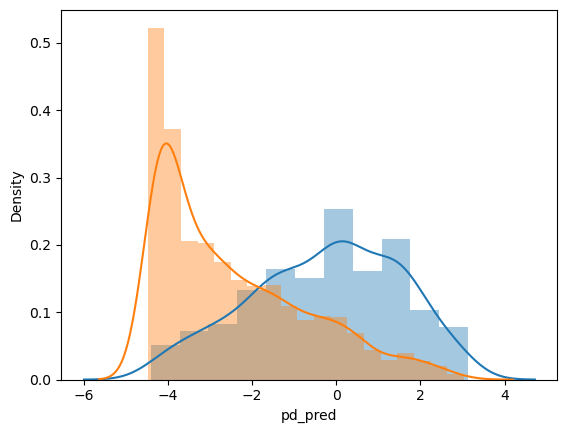

In [37]:
import seaborn as sns
sns.distplot(valid_output.query('pd_true==1').pd_pred)
sns.distplot(valid_output.query('pd_true==0').pd_pred)


/tmp/ipykernel_2535/276717808.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==1').pd_pred)
/tmp/ipykernel_2535/276717808.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_output.query('pd_true==0').pd_pred)


<Axes: xlabel='pd_pred', ylabel='Density'>

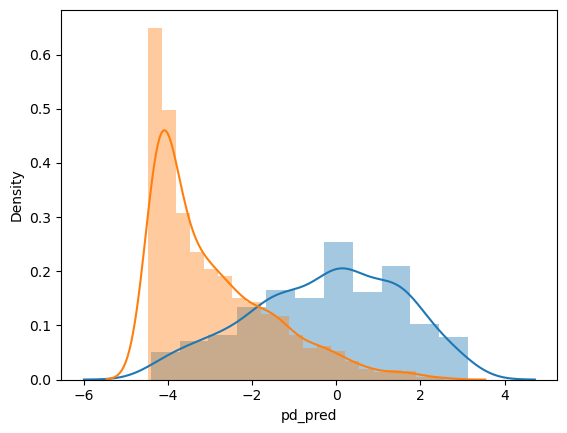

In [38]:
valid_output= valid_output[valid_output.overall_response != 'BL']
sns.distplot(valid_output.query('pd_true==1').pd_pred)
sns.distplot(valid_output.query('pd_true==0').pd_pred)


In [39]:
from sklearn.metrics import roc_auc_score
import matplotlib as plt

%matplotlib inline

In [40]:


# helper functions for performance evaluation


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    import itertools
    import numpy as np

    from sklearn.metrics import confusion_matrix
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

    
    
# now eval model function
# evaluate model auc
def eval_model(predicted, actual, graph=True):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import roc_curve
    
    outcome_counts = np.unique(actual, return_counts=True)[1]
    prob_outcome = outcome_counts[1] / (outcome_counts[0] + outcome_counts[1])

    print("AUC " + str(roc_auc_score(actual, predicted)))

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(actual, predicted)
    roc_auc = auc(fpr, tpr)

    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(actual, predicted)

    print('Outcome probability: ' + str(prob_outcome))

    
    print('Average precision score: {0:0.2f}'.format(
        average_precision))

    # best F1
    precision, recall, thresholds = precision_recall_curve(actual, predicted)

    
    F1 = 2*((precision*recall)/(precision+recall))
    print("Best F1: " + str(max(F1)))

    
    # threshold for best F1
    bestF1_thresh = thresholds[np.argmax(F1)]
    
    if graph==True:
        print('Best F1 threshold: ' + str(bestF1_thresh))
        return bestF1_thresh
    
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic: ' )
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



    import matplotlib.pyplot as plt

    
    plt.plot(recall, precision, color='b')
    plt.plot([0,1],[prob_outcome,prob_outcome], 'r--')
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))
    plt.show()



    print("Threshold for best F1:")
    print(bestF1_thresh)
    pred_outcome_best_f1_thresh = np.where(predicted >= bestF1_thresh,1,0)
    pred_outcome_05_thresh = np.where(predicted >= 0.5,1,0)
    
    # # predictions
    
    # # confusion matrix
    print("Confusion matrix at best F1 thresh:")
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(actual, pred_outcome_best_f1_thresh)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix, without normalization')
    print("Metrics at best F1 thresh (specificity is recall for negative class):")
    from sklearn.metrics import classification_report
    print(classification_report(actual, pred_outcome_best_f1_thresh, target_names=['No','Yes']))


    print("Confusion matrix at 0.5 thresh:")
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(actual, pred_outcome_05_thresh)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix, without normalization')
    print("Metrics at 0.5 thresh thresh (specificity is recall for negative class):")
    print(classification_report(actual, pred_outcome_05_thresh, target_names=['No','Yes']))


    # # plot threshold vs ppv curve
    plt.plot(thresholds, precision[0:len(precision)-1], color='b')

    plt.xlabel('Threshold probability')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('Threshold vs precision')
    plt.show()

    # histogram
    plt.hist(predicted)
    plt.title("Histogram")
    plt.xlabel("Predicted probability" )
    plt.ylabel("Frequency")
    plt.show()

    return bestF1_thresh
    

In [41]:
# AUROC for getting pd scans
roc_auc_score(valid_output.outcome, valid_output.pd_pred)


0.8728716794343657

In [42]:
eval_model(valid_output.pd_pred, valid_output.outcome, graph=True)

AUC 0.8728716794343657
Outcome probability: 0.21204579392732703
Average precision score: 0.68
Best F1: 0.6438923395445134
Best F1 threshold: -1.3581543


-1.3581543

In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6096 entries, 148 to 60469
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               6096 non-null   int64         
 1   dfci_mrn                 6096 non-null   int64         
 2   date                     6096 non-null   datetime64[ns]
 3   report_text              6096 non-null   object        
 4   protocol                 6096 non-null   object        
 5   overall_response         6096 non-null   object        
 6   narrative_text           6096 non-null   object        
 7   impression_text          3350 non-null   object        
 8   drop_this_obs            6096 non-null   bool          
 9   split                    6096 non-null   object        
 10  obs                      6096 non-null   int64         
 11  overall_response_factor  6096 non-null   int64         
 12  report_length            6096 n

In [44]:
test_day_text = test.copy()
test_day_text['text'] = test_day_text.text.astype(str)
test_day_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6096 entries, 148 to 60469
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               6096 non-null   int64         
 1   dfci_mrn                 6096 non-null   int64         
 2   date                     6096 non-null   datetime64[ns]
 3   report_text              6096 non-null   object        
 4   protocol                 6096 non-null   object        
 5   overall_response         6096 non-null   object        
 6   narrative_text           6096 non-null   object        
 7   impression_text          3350 non-null   object        
 8   drop_this_obs            6096 non-null   bool          
 9   split                    6096 non-null   object        
 10  obs                      6096 non-null   int64         
 11  overall_response_factor  6096 non-null   int64         
 12  report_length            6096 n

In [45]:
test_day_text = test_day_text.sort_values(by=['timepoint_id','dfci_mrn','time'])

test_day_text['text'] = test_day_text.groupby(['timepoint_id','dfci_mrn','time'])['text'].transform(lambda x: ' '.join(x))
test_day_text = test_day_text.groupby(['timepoint_id','dfci_mrn','time']).first().reset_index()
test_day_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   timepoint_id             2694 non-null   int64         
 1   dfci_mrn                 2694 non-null   int64         
 2   time                     2694 non-null   int64         
 3   Unnamed: 0               2694 non-null   int64         
 4   date                     2694 non-null   datetime64[ns]
 5   report_text              2694 non-null   object        
 6   protocol                 2694 non-null   object        
 7   overall_response         2694 non-null   object        
 8   narrative_text           2694 non-null   object        
 9   impression_text          1865 non-null   object        
 10  drop_this_obs            2694 non-null   bool          
 11  split                    2694 non-null   object        
 12  obs                      2694 non-

In [46]:
test_day_text.pd_true.value_counts()

0    2244
1     450
Name: pd_true, dtype: int64

In [47]:
test_day_text.outcome.value_counts()

 0    1720
-1     524
 1     450
Name: outcome, dtype: int64

In [33]:
all_reports.outcome.value_counts()

 0    38774
-1    12630
 1     9188
Name: outcome, dtype: int64

In [48]:
# write out actual test dataset
themodel = RecistModel()
themodel.load_state_dict(torch.load(prefix+'./recist_bert_nolongitudinal_pd.pt'))
themodel.to(device)

no_shuffle_test_dataset = data.DataLoader(RecistDataset(test.sort_values(by=['obs','time'])), batch_size=1, shuffle=False, num_workers=0)

dflist = []
for ids, mask, s_times, y_true in no_shuffle_test_dataset:
    thisframe = pd.DataFrame()
    
    with torch.no_grad():
        y_pred = themodel(ids.to(device), mask.to(device), s_times.to(device))
        
    thisframe = pd.DataFrame(y_pred.cpu().detach().numpy(), columns=['pd_pred'])
  
    dflist.append(thisframe)
    
resultframe = pd.concat(dflist, axis=0)
resultframe = resultframe.reset_index(drop=True)
    

output = test_day_text.reset_index(drop=True)



test_output = pd.concat([output, resultframe], axis=1)
test_output = test_output.sort_values(by=['timepoint_id','dfci_mrn', 'date']).reset_index(drop=True)






In [49]:
test_output = test_output.sort_values(by=['obs','dfci_mrn', 'date']).reset_index(drop=True)


#test_output.to_csv(prefix+'./test_set_output_pd_nolongitudinal.csv')

In [50]:
import seaborn as sns
import pandas as pd
import numpy as np
#test_output = pd.read_csv(prefix+'./test_set_output_pd_nolongitudinal.csv')


/tmp/ipykernel_2535/3481388163.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_output.query('pd_true==1').pd_pred)
/tmp/ipykernel_2535/3481388163.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_output.query('pd_true==0').pd_pred)


<Axes: xlabel='pd_pred', ylabel='Density'>

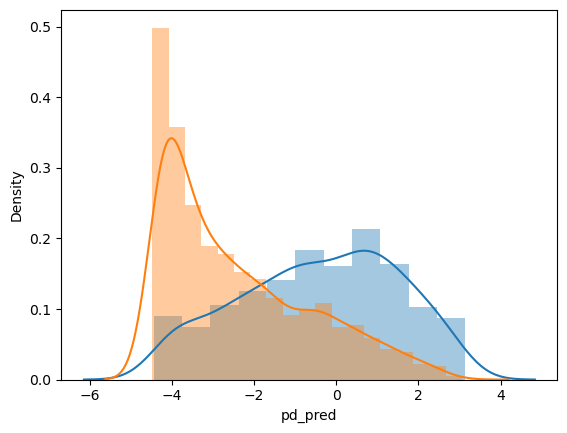

In [51]:
import seaborn as sns
sns.distplot(test_output.query('pd_true==1').pd_pred)
sns.distplot(test_output.query('pd_true==0').pd_pred)


/tmp/ipykernel_2535/708031868.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_output.query('pd_true==1').pd_pred)
/tmp/ipykernel_2535/708031868.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_output.query('pd_true==0').pd_pred)


<Axes: xlabel='pd_pred', ylabel='Density'>

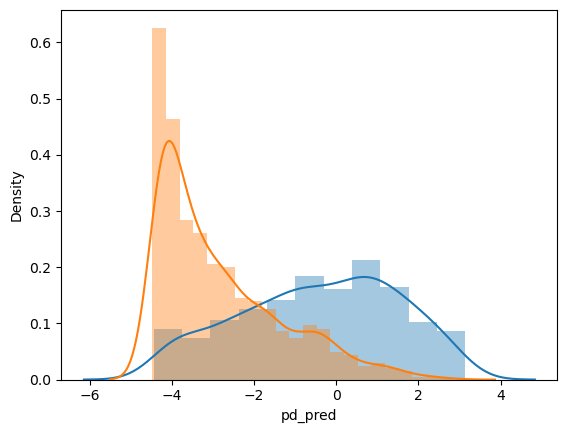

In [52]:
test_output= test_output[test_output.overall_response != 'BL']
sns.distplot(test_output.query('pd_true==1').pd_pred)
sns.distplot(test_output.query('pd_true==0').pd_pred)


In [53]:
from sklearn.metrics import roc_auc_score
import matplotlib as plt

%matplotlib inline

In [57]:


# helper functions for performance evaluation


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    import itertools
    import numpy as np

    from sklearn.metrics import confusion_matrix
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

    
    
# now eval model function
# evaluate model auc
def eval_model(predicted, actual, graph=True):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import roc_curve
    
    outcome_counts = np.unique(actual, return_counts=True)[1]
    prob_outcome = outcome_counts[1] / (outcome_counts[0] + outcome_counts[1])

    print("AUC " + str(roc_auc_score(actual, predicted)))

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(actual, predicted)
    roc_auc = auc(fpr, tpr)

    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(actual, predicted)

    print('Outcome probability: ' + str(prob_outcome))

    
    print('Average precision score: {0:0.2f}'.format(
        average_precision))

    # best F1
    precision, recall, thresholds = precision_recall_curve(actual, predicted)

    
    F1 = 2*((precision*recall)/(precision+recall))
    print("Best F1: " + str(max(F1)))

    
    # threshold for best F1
    bestF1_thresh = thresholds[np.argmax(F1)]
    
    if graph==True:
        print('Best F1 threshold: ' + str(bestF1_thresh))
        return bestF1_thresh
    
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic: ' )
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



    import matplotlib.pyplot as plt

    
    plt.plot(recall, precision, color='b')
    plt.plot([0,1],[prob_outcome,prob_outcome], 'r--')
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))
    plt.show()



    print("Threshold for best F1:")
    print(bestF1_thresh)
    pred_outcome_best_f1_thresh = np.where(predicted >= bestF1_thresh,1,0)
    pred_outcome_05_thresh = np.where(predicted >= 0.5,1,0)
    
    # # predictions
    
    # # confusion matrix
    print("Confusion matrix at best F1 thresh:")
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(actual, pred_outcome_best_f1_thresh)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix, without normalization')
    print("Metrics at best F1 thresh (specificity is recall for negative class):")
    from sklearn.metrics import classification_report
    print(classification_report(actual, pred_outcome_best_f1_thresh, target_names=['No','Yes']))


    print("Confusion matrix at 0.5 thresh:")
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(actual, pred_outcome_05_thresh)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix, without normalization')
    print("Metrics at 0.5 thresh thresh (specificity is recall for negative class):")
    print(classification_report(actual, pred_outcome_05_thresh, target_names=['No','Yes']))


    # # plot threshold vs ppv curve
    plt.plot(thresholds, precision[0:len(precision)-1], color='b')

    plt.xlabel('Threshold probability')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('Threshold vs precision')
    plt.show()

    # histogram
    plt.hist(predicted)
    plt.title("Histogram")
    plt.xlabel("Predicted probability" )
    plt.ylabel("Frequency")
    plt.show()

    return bestF1_thresh
    

In [58]:
# AUROC for getting pdscans
roc_auc_score(test_output.outcome, test_output.pd_pred)


0.8337635658914729

In [59]:
eval_model(test_output.pd_pred, test_output.outcome, graph=True)

AUC 0.8337635658914729
Outcome probability: 0.2073732718894009
Average precision score: 0.61
Best F1: 0.5901960784313726
Best F1 threshold: -1.2178264


-1.2178264